In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Loading the dataset & Pre trained word embeddings

In [4]:
import os
import sys
import torch
import torchtext.data
import torchtext.datasets
import numpy as np 
import time
from RNN import SentimentGRU
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from cs236781.train_results import FitResult
from cs236781 import plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device =", device)

device = cuda


load the data set:

In [5]:
if os.sys.platform == 'linux':
    data_dir = os.path.expanduser('~/HW4/project/GloVe')
else:
    data_dir = os.path.expanduser('~/.pytorch-datasets')
    
# torchtext Field objects parse text (e.g. a review) and create a tensor representation

# This Field object will be used for tokenizing the movie reviews text
review_parser = torchtext.data.Field(
    sequential=True, use_vocab=True, lower=True,
    init_token='<sos>', eos_token='<eos>', dtype=torch.long,
    tokenize='spacy', tokenizer_language='en_core_web_sm'
)

# This Field object converts the text labels into numeric values (0,1,2)
label_parser = torchtext.data.Field(
    is_target=True, sequential=False, unk_token=None, use_vocab=True
)

# Load SST, tokenize the samples and labels
# ds_X are Dataset objects which will use the parsers to return tensors
ds_train, ds_valid, ds_test = torchtext.datasets.SST.splits(
    review_parser, label_parser, root=data_dir
)
print(label_pareser)
n_train = len(ds_train)
print(f'Number of training   samples: {n_train}')
print(f'Number of validation samples: {len(ds_valid)}')
print(f'Number of test       samples: {len(ds_test)}')

/home/dor.bitton/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


NameError: name 'label_pareser' is not defined

In [173]:
for i in range(5):
    example = ds_test[i]
    label = example.label
    review = str.join(" ", example.text)
    print(f'sample#{i:04d} [{label:8s}]:\n > {review}\n')
neut = [i for i in range(2210) if ds_test[i].label == 'neutral']


sample#0000 [neutral ]:
 > effective but too - tepid biopic

sample#0001 [positive]:
 > if you sometimes like to go to the movies to have fun , wasabi is a good place to start .

sample#0002 [positive]:
 > emerges as something rare , an issue movie that 's so honest and keenly observed that it does n't feel like one .

sample#0003 [neutral ]:
 > the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .

sample#0004 [positive]:
 > offers that rare combination of entertainment and education .



As required, we'll use the pre-trained word embeddings of glove 6B.

In [6]:
#Vocabulary size is 40k, Embedding chosen size in 50
vocab, embeddings = [],[]
with open('./GloVe/glove.6B.50d.txt','rt',encoding='utf8') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)
    

add padding and unknown tokens to the embeddings array:

In [7]:
# Add the padding and the unknown tokens to the vocab and embeddings arrays

vocab = np.array(vocab) 
embeddings = np.array(embeddings)
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')

unk_emb = np.mean(embeddings, axis=0, keepdims=True)
pad_emb = np.zeros_like(embeddings[0]).reshape(1,-1)

embeddings = np.vstack((pad_emb, unk_emb, embeddings))

print(vocab[:10])

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']


## Baseline Model - Sentiment Analysis using RNN - GRU

As for the first part in our experiment


In [328]:
def train(model, optimizer, loss_fn, dl_train, dl_test, max_epochs=100,
          num_batches=400, save_path=None):
    
    best_test_acc = 0
    res = FitResult(max_epochs,[],[],[],[] )
    
    for epoch_idx in range(max_epochs):
        total_loss, num_correct = 0, 0
        num_samples = 0
        start_time = time.time()

        for batch_idx, batch in enumerate(dl_train):
            X, y = batch.text, batch.label

            # Forward pass
            _, y_pred_log_proba = model(X)
            
            # Backward pass
            optimizer.zero_grad()
            loss = loss_fn(y_pred_log_proba, y)
            loss.backward()

            # Weight updates
            optimizer.step()

            # Calculate accuracy
            total_loss += loss.item()
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_samples += y_pred.shape[0]
            num_correct += torch.sum(y_pred == y).float().item()

            if batch_idx == num_batches-1:
                break
        
        curr_test_loss, curr_test_acc = test_epoch(model, loss_fn, dl_test)
        res.test_loss.append(curr_test_loss)
        res.test_acc.append(curr_test_acc)
        
        curr_train_loss = total_loss /(num_batches)
        curr_train_acc = num_correct /(num_samples)
        res.train_loss.append(curr_train_loss)
        res.train_acc.append(curr_train_acc)
        
        
        print(f"Epoch #{epoch_idx}, loss={curr_train_loss:.3f}, accuracy={curr_train_acc:.3f}, elapsed={time.time()-start_time:.1f} sec")
        
        if save_path and curr_test_acc > best_test_acc:
            print("---saving model ---")
            torch.save(model, save_path)
            best_test_acc = curr_test_acc
            
    return res

In [58]:
def test_epoch(model, loss_fn, dataloader):
    model.eval()
    total_loss = 0
    num_correct = 0 
    num_batches = 0
    num_samples = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            num_batches = batch_idx
            X, y = batch.text, batch.label

            _, y_test = model(X)
            loss = loss_fn(y_test, y)
            total_loss += loss.item()
            
            # Calculate accuracy
            y_pred = torch.argmax(y_test, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            num_samples += y_pred.shape[0]

        num_batches += 1   
        
        test_loss = total_loss /(num_batches)
        test_acc = num_correct /(num_samples)
        print(f"Test Accuracy is # {test_acc:.3f}, # Test loss is {test_loss:.3f}")

    model.train()
    return test_loss, test_acc

In [178]:
EMBEDDING_DIM = 50
BATCH_SIZE = 8
HIDDEN_SIZE = 42
NUM_LAYERS = 2
DROPOUT = 0.7
LEARNING_RATE = 1e-4

In [422]:
dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)

review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

# Check test set Distribution
test_hist = torch.zeros(3, device=device)
for batch in dl_test:
    X, y = batch
    test_hist += torch.histc(y, bins=3, min=0, max=2)
print(test_hist)

train_hist= torch.zeros(3, device=device)
b=1

for batch in dl_train:
    X, y = batch
    if b==1:
        print(X.shape)
        b=0
        
    train_hist += torch.histc(y, bins=3, min=0, max=2)
print(train_hist)

tensor([909., 912., 389.], device='cuda:0')
torch.Size([31, 8])
tensor([3610., 3310., 1624.], device='cuda:0')


In [179]:
# defining the baseline model
model = SentimentGRU(embeddings, hidden_size=HIDDEN_SIZE,
                     num_layers=NUM_LAYERS, dropout=DROPOUT).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#weights = torch.FloatTensor([1, 1, 1.5]).to(device)
loss_fn = torch.nn.NLLLoss()


In [329]:
fit_res = train(model, optimizer, loss_fn, dl_train, dl_test, max_epochs=300,
      num_batches=500, save_path = "./models/sentimentGRU.pt")

Test Accuracy is # 0.411, # Test loss is 1.037
Epoch #0, loss=1.039, accuracy=0.434, elapsed=8.2 sec
---saving model ---


KeyboardInterrupt: 

(<Figure size 1152x720 with 4 Axes>,
 array([<AxesSubplot:title={'center':'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <AxesSubplot:title={'center':'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <AxesSubplot:title={'center':'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <AxesSubplot:title={'center':'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

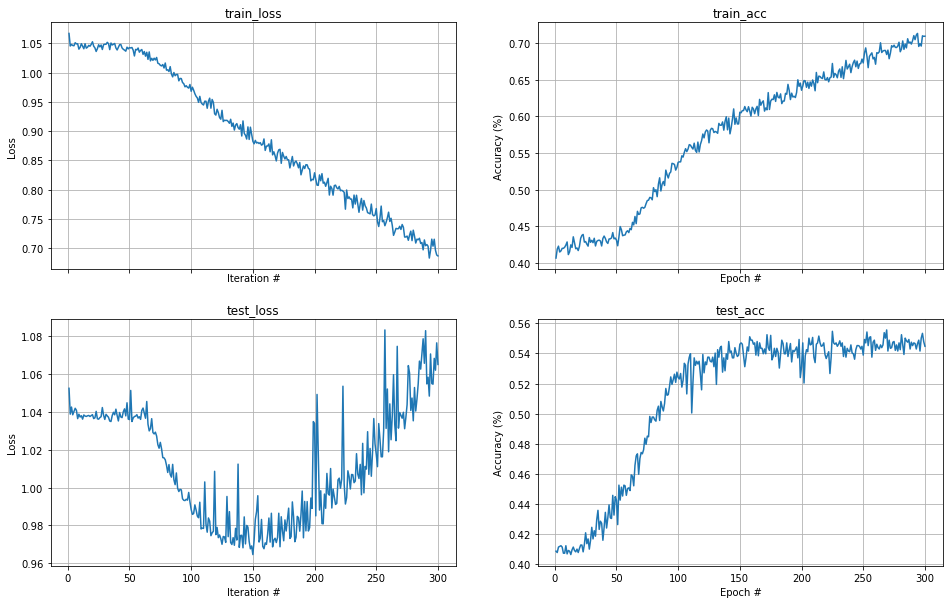

In [176]:
plot.plot_fit(fit_res)

In [ ]:
# Load the best model achieved during training
model = torch.load("./models/sentimentGRU.pt")
print(model)

In [8]:
# Self Attenttion Hyper parameters:

EMBEDDING_DIM = 50
BATCH_SIZE = 8
NUM_HEADS = 1
D_MODEL = 50
TWO_LAYERS = False
DROPOUT = 0.7
LEARNING_RATE = 1e-3

In [9]:
from SelfAttention import SentimentSelfAttention

dl_train, dl_valid, dl_test = torchtext.data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=BATCH_SIZE,
    shuffle=True, device=device)
review_parser.build_vocab(ds_train)
label_parser.build_vocab(ds_train)

model_attention = SentimentSelfAttention(embeddings,
                                         d_model=D_MODEL,
                                         num_heads=NUM_HEADS,
                                         dropout=DROPOUT,
                                         two_layers=TWO_LAYERS).to(device)

att_optimizer = torch.optim.Adam(model_attention.parameters(), lr=LEARNING_RATE)

print(model_attention)
print("trainable params:", 
      sum(p.numel() for p in model_attention.parameters() if p.requires_grad)) 


/home/dor.bitton/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


SentimentSelfAttention(
  (embedding_layer): Embedding(400002, 50)
  (PositionalEncoding): PositionalEncoding()
  (q_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (k_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (v_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (SelfAttention1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=50, out_features=50, bias=True)
  )
  (attention_out_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (dense_linear): Linear(in_features=50, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
trainable params: 20553


In [194]:
Attention_res = train(model_attention, att_optimizer, loss_fn, dl_train, dl_test, max_epochs=100,
          num_batches=500, save_path="./models/selfAttention.pt")

Test Accuracy is # 0.411, # Test loss is 1.037
Epoch #0, loss=1.045, accuracy=0.419, elapsed=7.5 sec
---saving model ---
Test Accuracy is # 0.411, # Test loss is 1.038
Epoch #1, loss=1.050, accuracy=0.423, elapsed=7.6 sec


KeyboardInterrupt: 

In [ ]:
plot.plot_fit(Attention_res)

In [10]:
# Load the best model achieved during training
model_attention = torch.load("./models/selfAttention.pt")
print(model_attention)

SentimentSelfAttention(
  (embedding_layer): Embedding(400002, 50)
  (PositionalEncoding): PositionalEncoding()
  (q_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (k_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (v_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (SelfAttention1): MultiheadAttention(
    (out_proj): _LinearWithBias(in_features=50, out_features=50, bias=True)
  )
  (attention_out_feedforward): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): ReLU()
  )
  (dense_linear): Linear(in_features=50, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay

# get the best predictions from the model
def get_preds_and_labels(model, dl, device):
    model.eval()
    all_preds = torch.tensor([]).to(device)
    GT_labels = torch.tensor([]).to(device)

    for i,batch in enumerate(dl):
        X, y = batch
        
        _, preds = model(X)
        preds = torch.argmax(preds, dim=1)
        
        all_preds = torch.cat((all_preds, preds), dim=0)
        GT_labels = torch.cat((GT_labels, y), dim=0)

    return all_preds , GT_labels

with torch.no_grad():
    # baseline VS SelfAttention Confusion matrices
    bl_best_preds, bl_GT_preds= get_preds_and_labels(model, dl_test, device)
    se_best_preds, se_GT_preds = get_preds_and_labels(model_attention, dl_test, device)
    
    # Now lets demonstrate the confusion matrix of the test set.
    IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
    class_names = ['Positive','Negative','Neutral']

    fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1 , figsize=(25, 10))
    disp = plot_confusion_matrix(IC, bl_best_preds.cpu(), bl_GT_preds.cpu(), display_labels=class_names, cmap=plt.cm.Blues, ax=ax1);
    disp.ax_.set_title('Baseline Confusion Matrix\n')

    disp = plot_confusion_matrix(IC, se_best_preds.cpu(), se_GT_preds.cpu() ,display_labels=class_names, cmap=plt.cm.Blues, ax=ax2);
    disp.ax_.set_title('Self-Attention Confusion Matrix\n')

    

NameError: name 'model' is not defined

## Attention Visualzation

In [11]:
def VisAttention(input_sentence, attentions):
     # Set up figure with colorbar
    fig = plt.figure(figsize=(25, 10))
    ax = fig.add_subplot()
    cax = ax.matshow(attentions.numpy(), cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence , rotation=90 , Fontsize=12)
    ax.set_yticklabels([''] + input_sentence, Fontsize=12)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.tight_layout()
    plt.show()



In [12]:
with torch.no_grad():
    CHOOSE_VAL = 6
    v = review_parser.vocab
    
    print(ds_test[CHOOSE_VAL].text)
    
    x = torch.LongTensor([v.stoi[x] for i, x in enumerate(ds_test[CHOOSE_VAL].text)]).reshape(-1,1).to(device)

    #Selected ony one sample
    _ , y_pred = model_attention(x)
    # print(x.shape, y, torch.exp(y_pred),"\n", x.data)
    
    weights = model_attention.last_attention_weights[0].squeeze().cpu()
    #print(weights.shape)
    
    review = ds_test[0]
    VisAttention(ds_test[CHOOSE_VAL].text, weights)



['steers', 'turns', 'in', 'a', 'snappy', 'screenplay', 'that', 'curls', 'at', 'the', 'edges', ';', 'it', "'s", 'so', 'clever', 'you', 'want', 'to', 'hate', 'it', '.']


NameError: name 'plt' is not defined